In [1]:
# name: Goh Jun Huang
# student id: 220399308

# Question 3

In [15]:
# this cell is fully retrieved from coursework specification and Lab7
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import random

train_set = torchvision.datasets.FashionMNIST(root = ".", train=True, download=True, transform=transforms.ToTensor())
test_set = torchvision.datasets.FashionMNIST(root = ".", train=False, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

# fix the seed to be able to get the same randomness across runs and hence reproducible outcomes
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
# if you are using CuDNN , otherwise you can just ignore
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

### Question 3.2

In [16]:
# this cell contains code refer to Lab7
class MyCNN(nn.Module):
    # initialize with ReLU as activation function
    def __init__(self, act_fn=nn.ReLU()):
        super(MyCNN, self).__init__()
        # define activation function variable for future use
        self.act_fn = act_fn
        self.cnn_model = nn.Sequential(
            # kernel_size -> 5
            # channel -> 32
            # output dimension = (28-5+1)/1 * (28-5+1)/1 * 32 = 24*24*32
            nn.Conv2d(1, 32, kernel_size = 5, stride=1),
            self.act_fn,
            # output dimension = (24-2+2)/2 * (24-2+2)/2 * 32 = 12*12*32
            nn.MaxPool2d(2, stride=2),
            # kernel_size -> 5
            # channel -> 64
            # output dimension = (12-5+1)/1 * (12-5+1)/1 * 64 = 8*8*64 
            nn.Conv2d(32, 64, kernel_size = 5, stride = 1),
            self.act_fn,
            # output dimension = (8-2+2)/2 * (8-2+2)/2 * 64 = 4*4*64
            nn.MaxPool2d(2, stride = 2)
        )
        self.fc_model = nn.Sequential(
            # size -> 1024
            nn.Linear(1024, 1024),
            self.act_fn,
            # size -> 1024
            nn.Linear(1024,256),
            self.act_fn,
            # rate -> 0.3
            # nn.Dropout(0.3),
            nn.Linear(256, 10)
        )
 
   
    def forward(self, x):
        x = self.cnn_model(x)
        x =x.view(x.size(0), -1)
        x = self.fc_model(x)
        return x



def weights_init(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        # init -> Xavier Uniform
        # torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.xavier_normal_(m.weight)        

def train(alpha=0.1, act_fn=nn.ReLU(), dropout=None):
    def evaluation(dataloader):
        total, correct = 0,0
        net.eval()
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, pred = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()
        return 100 * correct / total
    
    device = torch.device("cuda:0")

    net = MyCNN(act_fn).to(device)
    net.apply(weights_init)
    
    # add dropout rate for future use
    if dropout:
        net.fc_model = nn.Sequential(
            nn.Linear(1024, 1024),
            net.act_fn,
            nn.Linear(1024,256),
            net.act_fn,
            # rate -> 0.3
            nn.Dropout(dropout),
            nn.Linear(256, 10)
        )

    loss_fn = nn.CrossEntropyLoss()
    loss_fn.to(device)

    opt = torch.optim.SGD(list(net.parameters()), lr=alpha)

    loss_epoch_array = []
    max_epochs = 30
    loss_epoch = 0
    train_accuracy = []
    test_accuracy = []
    for epoch in range(max_epochs):
        loss_epoch = 0
        for i, data in enumerate(train_loader, 0):
            net.train()
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            opt.zero_grad()
            outputs = net(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            opt.step()
            loss_epoch += loss.item()

        loss_epoch_array.append(loss_epoch)
        train_accuracy.append(evaluation(train_loader))
        test_accuracy.append(evaluation(test_loader))
        print("Epoch {}: loss: {}, train accuracy: {}, valid accuracy:{}".format(epoch + 1, loss_epoch_array[-1], train_accuracy[-1], test_accuracy[-1]))
    return {"train_accuracy": train_accuracy, "test_accuracy": test_accuracy, "loss_epoch_array": loss_epoch_array}

In [4]:
ret = train()

Epoch 1: loss: 969.3826080337167, train accuracy: 87.345, valid accuracy:86.15
Epoch 2: loss: 607.459950055927, train accuracy: 89.285, valid accuracy:87.67
Epoch 3: loss: 518.5568338455632, train accuracy: 90.605, valid accuracy:88.66
Epoch 4: loss: 460.47685756906867, train accuracy: 91.845, valid accuracy:89.33
Epoch 5: loss: 415.22427535429597, train accuracy: 92.59833333333333, valid accuracy:89.71
Epoch 6: loss: 373.2612021965906, train accuracy: 93.79666666666667, valid accuracy:90.2
Epoch 7: loss: 336.7941636322066, train accuracy: 94.515, valid accuracy:90.61
Epoch 8: loss: 303.43109982647, train accuracy: 94.25333333333333, valid accuracy:90.4
Epoch 9: loss: 272.8792414474301, train accuracy: 95.98833333333333, valid accuracy:91.27
Epoch 10: loss: 243.85078513808548, train accuracy: 95.21, valid accuracy:90.03
Epoch 11: loss: 214.9920910326764, train accuracy: 96.40833333333333, valid accuracy:90.87
Epoch 12: loss: 200.73364569875412, train accuracy: 96.67, valid accuracy:90.

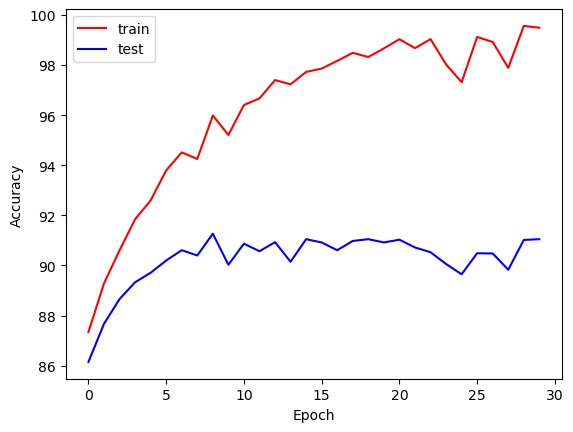

In [5]:
# this cell contains code refer to Lab7
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(ret["train_accuracy"], "r")
plt.plot(ret["test_accuracy"], "b")
plt.gca().legend(("train","test"))

# save the histogram as an image
plt.savefig("3_2_b.jpg")

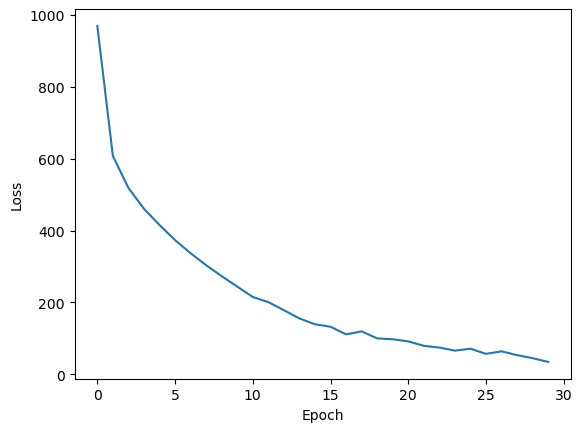

In [6]:
# this cell contains code refer to Lab7
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(ret["loss_epoch_array"])

# save the histogram as an image
plt.savefig("3_2_c.jpg")

### Question 3.3

In [10]:
print('Activation function: {}'.format('Tanh'))
train(act_fn=nn.Tanh())

Activation function: Tanh
Epoch 1: loss: 859.2154503576458, train accuracy: 87.69166666666666, valid accuracy:86.47
Epoch 2: loss: 598.4239165112376, train accuracy: 90.26333333333334, valid accuracy:88.26
Epoch 3: loss: 510.229942150414, train accuracy: 91.58666666666667, valid accuracy:89.49
Epoch 4: loss: 440.7759171780199, train accuracy: 90.59333333333333, valid accuracy:87.75
Epoch 5: loss: 388.82575583830476, train accuracy: 92.53833333333333, valid accuracy:89.02
Epoch 6: loss: 341.99327325914055, train accuracy: 94.52166666666666, valid accuracy:90.41
Epoch 7: loss: 297.7531350487843, train accuracy: 95.58, valid accuracy:90.33
Epoch 8: loss: 258.79011983890086, train accuracy: 95.965, valid accuracy:90.76
Epoch 9: loss: 221.27151436998975, train accuracy: 95.99833333333333, valid accuracy:90.46
Epoch 10: loss: 189.21996131772175, train accuracy: 97.195, valid accuracy:90.95
Epoch 11: loss: 159.7774333327543, train accuracy: 97.47, valid accuracy:90.76
Epoch 12: loss: 134.5876

{'train_accuracy': [87.69166666666666,
  90.26333333333334,
  91.58666666666667,
  90.59333333333333,
  92.53833333333333,
  94.52166666666666,
  95.58,
  95.965,
  95.99833333333333,
  97.195,
  97.47,
  97.88166666666666,
  97.81833333333333,
  98.985,
  99.08166666666666,
  99.01333333333334,
  99.78666666666666,
  99.895,
  99.985,
  99.985,
  100.0,
  100.0,
  100.0,
  100.0,
  100.0,
  100.0,
  100.0,
  100.0,
  100.0,
  100.0],
 'test_accuracy': [86.47,
  88.26,
  89.49,
  87.75,
  89.02,
  90.41,
  90.33,
  90.76,
  90.46,
  90.95,
  90.76,
  91.2,
  90.86,
  90.93,
  91.15,
  91.22,
  91.37,
  91.54,
  91.87,
  91.84,
  91.94,
  91.92,
  91.95,
  91.9,
  91.89,
  91.89,
  91.87,
  91.87,
  91.88,
  91.85],
 'loss_epoch_array': [859.2154503576458,
  598.4239165112376,
  510.229942150414,
  440.7759171780199,
  388.82575583830476,
  341.99327325914055,
  297.7531350487843,
  258.79011983890086,
  221.27151436998975,
  189.21996131772175,
  159.7774333327543,
  134.58768089779187

In [11]:
print('Activation function: {}'.format('Sigmoid'))
train(act_fn=nn.Sigmoid())

Activation function: Sigmoid
Epoch 1: loss: 4339.868419408798, train accuracy: 10.0, valid accuracy:10.0
Epoch 2: loss: 4319.385297060013, train accuracy: 10.0, valid accuracy:10.0
Epoch 3: loss: 4188.411675453186, train accuracy: 39.483333333333334, valid accuracy:39.25
Epoch 4: loss: 1836.36216917634, train accuracy: 71.05, valid accuracy:70.35
Epoch 5: loss: 1355.1207852810621, train accuracy: 74.005, valid accuracy:73.36
Epoch 6: loss: 1209.5593990534544, train accuracy: 75.64666666666666, valid accuracy:74.76
Epoch 7: loss: 1107.0959377586842, train accuracy: 78.50333333333333, valid accuracy:77.84
Epoch 8: loss: 1015.5368535667658, train accuracy: 80.15666666666667, valid accuracy:78.97
Epoch 9: loss: 945.636850707233, train accuracy: 82.76, valid accuracy:81.44
Epoch 10: loss: 891.940844476223, train accuracy: 83.72333333333333, valid accuracy:82.66
Epoch 11: loss: 846.7321581915021, train accuracy: 84.08166666666666, valid accuracy:83.1
Epoch 12: loss: 803.5481092333794, train 

{'train_accuracy': [10.0,
  10.0,
  39.483333333333334,
  71.05,
  74.005,
  75.64666666666666,
  78.50333333333333,
  80.15666666666667,
  82.76,
  83.72333333333333,
  84.08166666666666,
  83.92833333333333,
  86.17,
  86.01166666666667,
  86.93,
  87.01,
  86.37666666666667,
  87.73833333333333,
  87.16666666666667,
  88.35833333333333,
  87.97666666666667,
  88.93,
  89.40833333333333,
  89.23666666666666,
  89.08666666666667,
  89.30833333333334,
  89.99166666666666,
  89.81833333333333,
  90.23,
  90.22833333333334],
 'test_accuracy': [10.0,
  10.0,
  39.25,
  70.35,
  73.36,
  74.76,
  77.84,
  78.97,
  81.44,
  82.66,
  83.1,
  82.81,
  85.01,
  84.94,
  85.66,
  86.15,
  85.35,
  86.34,
  86.19,
  87.24,
  86.7,
  87.77,
  87.93,
  87.95,
  87.23,
  87.9,
  88.39,
  88.16,
  88.63,
  88.68],
 'loss_epoch_array': [4339.868419408798,
  4319.385297060013,
  4188.411675453186,
  1836.36216917634,
  1355.1207852810621,
  1209.5593990534544,
  1107.0959377586842,
  1015.536853566765

In [12]:
print('Activation function: {}'.format('ELU'))
train(act_fn=nn.ELU())

Activation function: ELU
Epoch 1: loss: 861.7078629992902, train accuracy: 87.48, valid accuracy:86.49
Epoch 2: loss: 593.6476743798703, train accuracy: 90.29333333333334, valid accuracy:88.69
Epoch 3: loss: 508.54698218777776, train accuracy: 90.91833333333334, valid accuracy:89.08
Epoch 4: loss: 448.0098500037566, train accuracy: 91.64, valid accuracy:89.14
Epoch 5: loss: 397.0564305940643, train accuracy: 93.48333333333333, valid accuracy:89.83
Epoch 6: loss: 356.79209494544193, train accuracy: 94.585, valid accuracy:90.64
Epoch 7: loss: 321.4118592343293, train accuracy: 94.805, valid accuracy:90.58
Epoch 8: loss: 284.7209540018812, train accuracy: 95.46166666666667, valid accuracy:90.43
Epoch 9: loss: 256.3765732147731, train accuracy: 95.35, valid accuracy:90.13
Epoch 10: loss: 218.37179154762998, train accuracy: 96.19666666666667, valid accuracy:90.37
Epoch 11: loss: 208.78590320935473, train accuracy: 96.39, valid accuracy:90.25
Epoch 12: loss: 197.8190393000259, train accuracy

{'train_accuracy': [87.48,
  90.29333333333334,
  90.91833333333334,
  91.64,
  93.48333333333333,
  94.585,
  94.805,
  95.46166666666667,
  95.35,
  96.19666666666667,
  96.39,
  96.82833333333333,
  97.30166666666666,
  97.75166666666667,
  97.46833333333333,
  98.12333333333333,
  98.26166666666667,
  97.69,
  98.49166666666666,
  98.35666666666667,
  98.06,
  98.85166666666667,
  98.44166666666666,
  98.65833333333333,
  98.90833333333333,
  97.85,
  98.89666666666666,
  98.715,
  98.07833333333333,
  99.31166666666667],
 'test_accuracy': [86.49,
  88.69,
  89.08,
  89.14,
  89.83,
  90.64,
  90.58,
  90.43,
  90.13,
  90.37,
  90.25,
  90.4,
  90.49,
  90.83,
  90.32,
  90.97,
  91.11,
  90.3,
  90.67,
  90.52,
  89.79,
  90.6,
  89.88,
  90.25,
  90.63,
  89.84,
  90.68,
  90.47,
  90.08,
  90.68],
 'loss_epoch_array': [861.7078629992902,
  593.6476743798703,
  508.54698218777776,
  448.0098500037566,
  397.0564305940643,
  356.79209494544193,
  321.4118592343293,
  284.72095400

### Question 3.4

In [13]:
lr = 0.001
print('Learning rate: {}'.format(str(lr)))
train(alpha=lr)

Learning rate: 0.001
Epoch 1: loss: 3540.5005546212196, train accuracy: 64.05, valid accuracy:63.89
Epoch 2: loss: 1576.022399276495, train accuracy: 71.19666666666667, valid accuracy:70.59
Epoch 3: loss: 1358.3105807900429, train accuracy: 75.18166666666667, valid accuracy:74.37
Epoch 4: loss: 1259.803830832243, train accuracy: 75.76, valid accuracy:74.55
Epoch 5: loss: 1189.6190608143806, train accuracy: 76.62833333333333, valid accuracy:75.69
Epoch 6: loss: 1132.4888194054365, train accuracy: 78.28833333333333, valid accuracy:77.41
Epoch 7: loss: 1084.1783754080534, train accuracy: 79.45666666666666, valid accuracy:78.38
Epoch 8: loss: 1042.3093764930964, train accuracy: 79.01, valid accuracy:77.75
Epoch 9: loss: 1004.9167941957712, train accuracy: 80.85333333333334, valid accuracy:79.77
Epoch 10: loss: 974.1360346972942, train accuracy: 80.61166666666666, valid accuracy:79.27
Epoch 11: loss: 944.4672198742628, train accuracy: 82.19, valid accuracy:81.18
Epoch 12: loss: 920.70233985

{'train_accuracy': [64.05,
  71.19666666666667,
  75.18166666666667,
  75.76,
  76.62833333333333,
  78.28833333333333,
  79.45666666666666,
  79.01,
  80.85333333333334,
  80.61166666666666,
  82.19,
  82.98833333333333,
  82.66833333333334,
  83.53166666666667,
  84.01,
  84.55833333333334,
  84.32,
  84.94166666666666,
  84.32,
  84.88833333333334,
  85.52666666666667,
  84.57333333333334,
  85.45,
  86.01,
  86.18333333333334,
  86.96166666666667,
  87.20833333333333,
  87.205,
  87.25,
  87.57166666666667],
 'test_accuracy': [63.89,
  70.59,
  74.37,
  74.55,
  75.69,
  77.41,
  78.38,
  77.75,
  79.77,
  79.27,
  81.18,
  81.91,
  81.41,
  82.55,
  82.89,
  83.66,
  83.27,
  83.72,
  83.41,
  84.01,
  84.51,
  83.18,
  84.27,
  85.0,
  84.84,
  85.69,
  85.81,
  85.86,
  85.96,
  86.43],
 'loss_epoch_array': [3540.5005546212196,
  1576.022399276495,
  1358.3105807900429,
  1259.803830832243,
  1189.6190608143806,
  1132.4888194054365,
  1084.1783754080534,
  1042.3093764930964,
 

In [4]:
lr = 0.1
print('Learning rate: {}'.format(str(lr)))
train(alpha=lr)

Epoch 1: loss: 969.3826080337167, train accuracy: 87.345, valid accuracy:86.15
Epoch 2: loss: 607.459950055927, train accuracy: 89.285, valid accuracy:87.67
Epoch 3: loss: 518.5568338455632, train accuracy: 90.605, valid accuracy:88.66
Epoch 4: loss: 460.47685756906867, train accuracy: 91.845, valid accuracy:89.33
Epoch 5: loss: 415.22427535429597, train accuracy: 92.59833333333333, valid accuracy:89.71
Epoch 6: loss: 373.2612021965906, train accuracy: 93.79666666666667, valid accuracy:90.2
Epoch 7: loss: 336.7941636322066, train accuracy: 94.515, valid accuracy:90.61
Epoch 8: loss: 303.43109982647, train accuracy: 94.25333333333333, valid accuracy:90.4
Epoch 9: loss: 272.8792414474301, train accuracy: 95.98833333333333, valid accuracy:91.27
Epoch 10: loss: 243.85078513808548, train accuracy: 95.21, valid accuracy:90.03
Epoch 11: loss: 214.9920910326764, train accuracy: 96.40833333333333, valid accuracy:90.87
Epoch 12: loss: 200.73364569875412, train accuracy: 96.67, valid accuracy:90.

In [11]:
lr = 0.5
print('Learning rate: {}'.format(str(lr)))
train(alpha=lr)

Learning rate: 0.5
Epoch 1: loss: 1104.5341430827975, train accuracy: 86.08666666666667, valid accuracy:84.5
Epoch 2: loss: 695.9205680601299, train accuracy: 85.45333333333333, valid accuracy:84.31
Epoch 3: loss: 616.4018143918365, train accuracy: 89.62, valid accuracy:87.08
Epoch 4: loss: 562.4380979314446, train accuracy: 90.46833333333333, valid accuracy:87.74
Epoch 5: loss: 525.6859058253467, train accuracy: 91.21666666666667, valid accuracy:87.94
Epoch 6: loss: 489.79845510423183, train accuracy: 91.03166666666667, valid accuracy:87.35
Epoch 7: loss: 472.98673960380256, train accuracy: 91.26, valid accuracy:87.57
Epoch 8: loss: 461.5368510950357, train accuracy: 91.95166666666667, valid accuracy:87.9
Epoch 9: loss: 481.62954598106444, train accuracy: 92.24333333333334, valid accuracy:88.35
Epoch 10: loss: 446.63836662098765, train accuracy: 91.55666666666667, valid accuracy:87.37
Epoch 11: loss: 431.148299774155, train accuracy: 91.765, valid accuracy:87.7
Epoch 12: loss: 424.397

{'train_accuracy': [86.08666666666667,
  85.45333333333333,
  89.62,
  90.46833333333333,
  91.21666666666667,
  91.03166666666667,
  91.26,
  91.95166666666667,
  92.24333333333334,
  91.55666666666667,
  91.765,
  92.675,
  93.79,
  92.12666666666667,
  92.06,
  92.38333333333334,
  92.29166666666667,
  92.05833333333334,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0],
 'test_accuracy': [84.5,
  84.31,
  87.08,
  87.74,
  87.94,
  87.35,
  87.57,
  87.9,
  88.35,
  87.37,
  87.7,
  87.86,
  88.45,
  87.18,
  87.08,
  87.55,
  86.9,
  86.79,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0],
 'loss_epoch_array': [1104.5341430827975,
  695.9205680601299,
  616.4018143918365,
  562.4380979314446,
  525.6859058253467,
  489.79845510423183,
  472.98673960380256,
  461.5368510950357,
  481.62954598106444,
  446.63836662098765,
  431.148299774155,
  424.3973522176966,
  420.5593956988305,
  433.02

In [10]:
lr = 1
print('Learning rate: {}'.format(str(lr)))
train(alpha=lr)

Learning rate: 1
Epoch 1: loss: 4334.624948263168, train accuracy: 10.0, valid accuracy:10.0
Epoch 2: loss: 4331.528424978256, train accuracy: 10.0, valid accuracy:10.0
Epoch 3: loss: 4331.87432050705, train accuracy: 10.0, valid accuracy:10.0
Epoch 4: loss: 4331.479244232178, train accuracy: 10.0, valid accuracy:10.0
Epoch 5: loss: 4330.954448461533, train accuracy: 10.0, valid accuracy:10.0
Epoch 6: loss: 4331.1983478069305, train accuracy: 10.0, valid accuracy:10.0
Epoch 7: loss: 4331.577811717987, train accuracy: 10.0, valid accuracy:10.0
Epoch 8: loss: 4332.351108312607, train accuracy: 10.0, valid accuracy:10.0
Epoch 9: loss: 4332.132206916809, train accuracy: 10.0, valid accuracy:10.0
Epoch 10: loss: 4329.864184141159, train accuracy: 10.0, valid accuracy:10.0
Epoch 11: loss: 4331.443961143494, train accuracy: 10.0, valid accuracy:10.0
Epoch 12: loss: 4331.011340856552, train accuracy: 10.0, valid accuracy:10.0
Epoch 13: loss: 4331.4813685417175, train accuracy: 10.0, valid accu

{'train_accuracy': [10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0],
 'test_accuracy': [10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0],
 'loss_epoch_array': [4334.624948263168,
  4331.528424978256,
  4331.87432050705,
  4331.479244232178,
  4330.954448461533,
  4331.1983478069305,
  4331.577811717987,
  4332.351108312607,
  4332.132206916809,
  4329.864184141159,
  4331.443961143494,
  4331.011340856552,
  4331.4813685417175,
  4332.038800001144,
  4332.513762950897,
  4331.596029996872,
  4331.142994642258,
  4330.949161052704,
  4331.626976251602,
  4331.5809807777405,
  4331.812284708023,
  4331.828303337097,

In [9]:
lr = 10
print('Learning rate: {}'.format(str(lr)))
train(alpha=lr)

Learning rate: 10
Epoch 1: loss: nan, train accuracy: 10.0, valid accuracy:10.0
Epoch 2: loss: nan, train accuracy: 10.0, valid accuracy:10.0
Epoch 3: loss: nan, train accuracy: 10.0, valid accuracy:10.0
Epoch 4: loss: nan, train accuracy: 10.0, valid accuracy:10.0
Epoch 5: loss: nan, train accuracy: 10.0, valid accuracy:10.0
Epoch 6: loss: nan, train accuracy: 10.0, valid accuracy:10.0
Epoch 7: loss: nan, train accuracy: 10.0, valid accuracy:10.0
Epoch 8: loss: nan, train accuracy: 10.0, valid accuracy:10.0
Epoch 9: loss: nan, train accuracy: 10.0, valid accuracy:10.0
Epoch 10: loss: nan, train accuracy: 10.0, valid accuracy:10.0
Epoch 11: loss: nan, train accuracy: 10.0, valid accuracy:10.0
Epoch 12: loss: nan, train accuracy: 10.0, valid accuracy:10.0
Epoch 13: loss: nan, train accuracy: 10.0, valid accuracy:10.0
Epoch 14: loss: nan, train accuracy: 10.0, valid accuracy:10.0
Epoch 15: loss: nan, train accuracy: 10.0, valid accuracy:10.0
Epoch 16: loss: nan, train accuracy: 10.0, val

{'train_accuracy': [10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0],
 'test_accuracy': [10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0],
 'loss_epoch_array': [nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan]}

### Question 3.5

In [18]:
class MyCNN(nn.Module):
    # initialize with ReLU as activation function
    def __init__(self, act_fn=nn.ReLU()):
        super(MyCNN, self).__init__()
        # define activation function variable for future use
        self.act_fn = act_fn
        self.cnn_model = nn.Sequential(
            # kernel_size -> 5
            # channel -> 32
            # output dimension = (28-5+1)/1 * (28-5+1)/1 * 32 = 24*24*32
            nn.Conv2d(1, 32, kernel_size = 5, stride=1),
            self.act_fn,
            # output dimension = (24-2+2)/2 * (24-2+2)/2 * 32 = 12*12*32
            nn.MaxPool2d(2, stride=2),
            # kernel_size -> 5
            # channel -> 64
            # output dimension = (12-5+1)/1 * (12-5+1)/1 * 64 = 8*8*64 
            nn.Conv2d(32, 64, kernel_size = 5, stride = 1),
            self.act_fn,
            # output dimension = (8-2+2)/2 * (8-2+2)/2 * 64 = 4*4*64
            nn.MaxPool2d(2, stride = 2)
        )
        self.fc_model = nn.Sequential(
            # size -> 1024
            nn.Linear(1024, 1024),
            self.act_fn,
            # size -> 1024
            nn.Linear(1024,256),
            self.act_fn,
            # rate -> 0.3
            nn.Dropout(0.3),
            nn.Linear(256, 10)
        )
 
   
    def forward(self, x):
        x = self.cnn_model(x)
        x =x.view(x.size(0), -1)
        x = self.fc_model(x)
        return x

In [19]:
train()

Epoch 1: loss: 1018.5951657816768, train accuracy: 86.43333333333334, valid accuracy:85.52
Epoch 2: loss: 623.3457070365548, train accuracy: 89.65166666666667, valid accuracy:88.28
Epoch 3: loss: 541.0895348899066, train accuracy: 90.74333333333334, valid accuracy:88.8
Epoch 4: loss: 486.84440389461815, train accuracy: 90.615, valid accuracy:88.65
Epoch 5: loss: 443.74952871352434, train accuracy: 92.54, valid accuracy:90.18
Epoch 6: loss: 405.0331130353734, train accuracy: 92.68833333333333, valid accuracy:89.78
Epoch 7: loss: 371.3891759291291, train accuracy: 93.35333333333334, valid accuracy:90.39
Epoch 8: loss: 342.5216082963161, train accuracy: 94.16166666666666, valid accuracy:90.4
Epoch 9: loss: 316.3897955529392, train accuracy: 94.555, valid accuracy:90.39
Epoch 10: loss: 290.34649491030723, train accuracy: 95.45833333333333, valid accuracy:90.98
Epoch 11: loss: 269.34573110425845, train accuracy: 95.23166666666667, valid accuracy:90.44
Epoch 12: loss: 241.01180186402053, tra

{'train_accuracy': [86.43333333333334,
  89.65166666666667,
  90.74333333333334,
  90.615,
  92.54,
  92.68833333333333,
  93.35333333333334,
  94.16166666666666,
  94.555,
  95.45833333333333,
  95.23166666666667,
  95.74666666666667,
  96.99,
  97.27333333333333,
  97.03166666666667,
  97.19,
  97.44833333333334,
  97.62,
  98.08666666666667,
  97.455,
  98.31,
  98.33333333333333,
  98.72333333333333,
  98.68333333333334,
  98.49333333333334,
  98.555,
  99.135,
  98.88666666666667,
  98.91166666666666,
  99.01833333333333],
 'test_accuracy': [85.52,
  88.28,
  88.8,
  88.65,
  90.18,
  89.78,
  90.39,
  90.4,
  90.39,
  90.98,
  90.44,
  90.67,
  91.05,
  91.3,
  90.62,
  90.66,
  90.58,
  90.72,
  90.85,
  90.05,
  90.95,
  90.55,
  90.76,
  91.21,
  90.74,
  90.98,
  90.77,
  90.67,
  91.02,
  90.88],
 'loss_epoch_array': [1018.5951657816768,
  623.3457070365548,
  541.0895348899066,
  486.84440389461815,
  443.74952871352434,
  405.0331130353734,
  371.3891759291291,
  342.52160